# DCGAN Painter

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
from PIL import Image
import os.path as osp
import matplotlib.pyplot as plt
import shutil


## Problem Description

The goal of this project is to create a model which is able to create a GAN which can create images which represent the original image but in the style of Monet when fed new images.


The dataset for this project contains four files: monet_jpg, monet_tfrec, photo_jpg, and photo_tfrec. 

Both monet_jpg and monet_tfrec contain 300 Monet paintings size 256x256 the only difference is in the file type. 

Both photo_jpg and photo_tfrec contain 7028 photos size 256x256 the only difference is in the file type.

For this project we will only use the .jpg file type images.

# EDA

In [2]:
#Define a class to create a dataset from the image directories and turn those images into tensor files
class getDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.fn = os.listdir(image_dir)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    def __getitem__(self, index):
        file_name = self.fn[index]
        image_file = osp.join(self.image_dir, file_name)

        img = Image.open(image_file)
        img = self.transform(img)
        return img
    def __len__(self):
        return len(self.fn)
monet = getDataset('../input/gan-getting-started/monet_jpg')

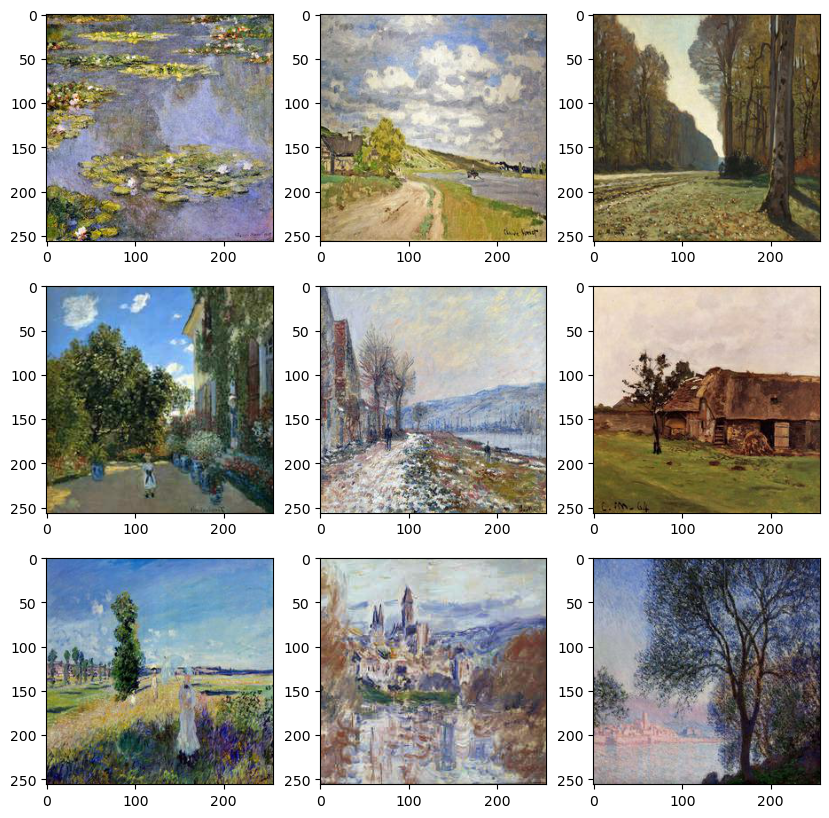

In [3]:
#Plot the first 9 monet images
fig, axes = plt.subplots(3,3, figsize = (10,10))
for i in range(9):
    ax = plt.subplot(3,3, i+1)
    ax.imshow(monet[i].permute(1,2,0))
    



The data itself is already cleaned so there is no work to do. For this project we will implement a basic DCGAN using pytorch.

## Model Architecture

Here we will write out a basic Discriminator and Generator function. Each function will use LeakyReLU instead of ReLU so we need to worry less about the initialization. We will also include Batchnormalization after each LeakyReLU layer for regularization. Both functions will use Sigmoid activation functions.

In [85]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, val):
        return self.main(val)
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(3, 512, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), 
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), 
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
  
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16),
      
            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, val):
        return self.main(val)




Here we will create a series of helper functions that will let us train our DCGAN effectively 

In [5]:
#use pytorchs basic functions to run on GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

#initialize our values for the DCGAN  
def initialize(dataset, batch_size, lr, beta1, beta2, epochs):
    G_loss = []
    D_loss = []
    G = Generator().to(device)
    D = Discriminator().to(device)
    epochs = epochs
    dl = DataLoader(dataset, batch_size, shuffle = True)
    Dmizer = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta1, beta2))
    Gmizer = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta1, beta2))
    loss = nn.BCELoss()
    return G, D, epochs, dl, Dmizer, Gmizer, loss, batch_size, lr, beta1, beta2
    
#Update our Discriminator loss based on real image evaluation
def update_D_real(D, label, val):
    D.zero_grad()
    output = D(val).view(-1)
    error = loss(output, label)
    error.backward()
    return error

#Update our Discriminator loss based on fake image evaluation
def update_D_fake(D, G, label, val):
    label.fill_(0)
    noise = torch.randn(val.shape[0], 64, 1, 1, device=device)
    fake = G(noise)
    output = D(fake.detach()).view(-1)
    error = loss(output, label)
    error.backward()
    return fake, error

#Update our Generator based on our Discriminators evaluation
def update_G(D, label, fake):
    label.fill_(1)
    G.zero_grad()
    output = D(fake).view(-1)
    error = loss(output, label)
    error.backward()
    return error

#train our model
def train_and_graph(G, D, dl, epochs, Dmizer, Gmizer, loss, batch_size, lr, beta1, beta2):
    G_loss = []
    D_fake_loss = []
    D_real_loss = []

    for epoch in range(epochs):
        for i, val in enumerate(dl):
            val = val.to(device)
            label = torch.full((val.shape[0],), 1, dtype=torch.float, device=device)
            e1 = update_D_real(D, label, val)
            fake, e2 = update_D_fake(D, G, label, val)
            Dmizer.step()

            error_G = update_G(D, label, fake)
            Gmizer.step()
        
            G_loss.append(error_G.item())
            D_fake_loss.append(e2.item())
            D_real_loss.append(e1.item())
            
    plt.figure(figsize=(10,5))
    plt.title(f"Loss in training, Batch Size: {batch_size}, Epochs: {epochs}, LR: {lr}, Beta1: {beta1}, Beta2: {beta2}")
    plt.plot(G_loss,label="G")
    plt.plot(D_fake_loss,label="D_fake")
    plt.plot(D_real_loss,label="D_real")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

running on the GPU


# Models and Results

For this project DCGAN is a very valid model because the point of this project is to generate new images based off input images but taking into account the style of Monet. As such it's necessary to use a generative network and DCGAN is an effective generative network.

In this section we will train 6 models with varying hyperparameters and plot their losses to try to determine which model is best.

The hyperparamaters to vary will be:
1. Batch_size
2. Epochs
3. Learning rate
4. Beta1 (ADAM optimizer input)
5. Beta2 (ADAM optimizer input)

### Batch Size: 64, Epochs: 100, LR: 0.001, Beta1: 0.1, Beta2: 0.9

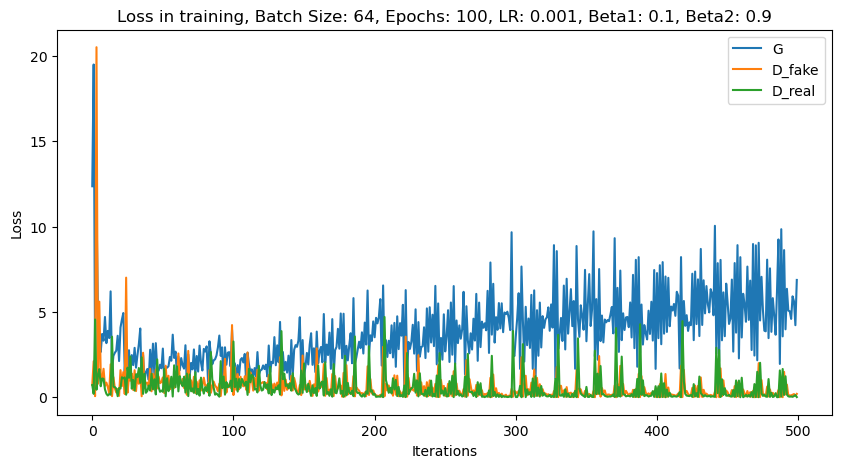

In [6]:
G, D, epochs, dl, Dmizer, Gmizer, loss, batch_size, lr, beta1, beta2 = initialize(monet, 64, 0.001, 0.1, 0.9, 100)

train_and_graph(G, D, dl, epochs, Dmizer, Gmizer, loss, batch_size, lr, beta1, beta2)

### Batch Size: 64, Epochs: 100, LR: 0.0001, Beta1: 0.1, Beta2: 0.9

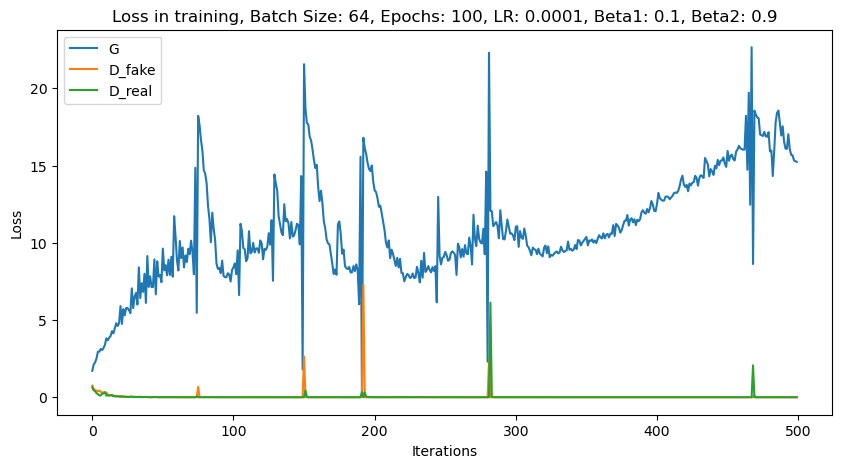

In [7]:
G_2, D_2, epochs_2, dl, Dmizer_2, Gmizer_2, loss, batch_size_2, lr_2, beta1, beta2 = initialize(monet, 64, 0.0001, 0.1, 0.9, 100)

train_and_graph(G_2, D_2, dl, epochs_2, Dmizer_2, Gmizer_2, loss, batch_size_2, lr_2, beta1, beta2)

### Batch Size: 64, Epochs: 100, LR: 0.1, Beta1: 0.1, Beta2: 0.9

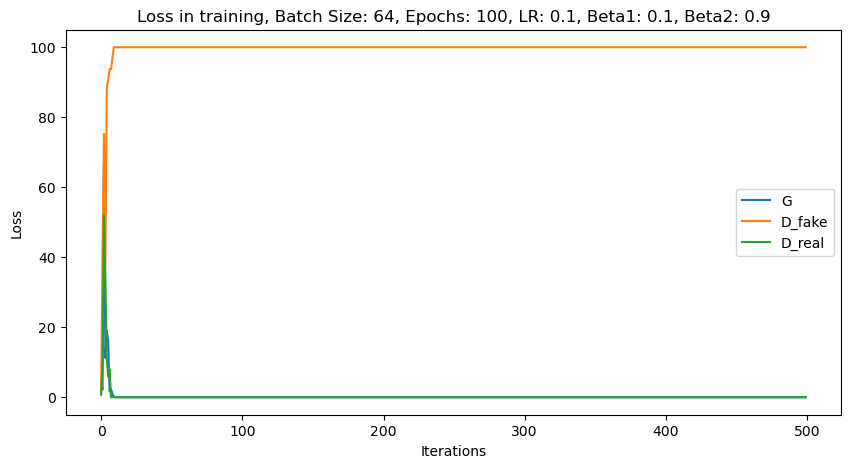

In [8]:
G_3, D_3, epochs_3, dl, Dmizer_3, Gmizer_3, loss, batch_size_3, lr_3, beta1, beta2 = initialize(monet, 64, 0.1, 0.1, 0.9, 100)

train_and_graph(G_3, D_3, dl, epochs_3, Dmizer_3, Gmizer_3, loss, batch_size_3, lr_3, beta1, beta2)

### Batch Size: 32, Epochs: 100, LR: 0.001, Beta1: 0.1, Beta2: 0.9

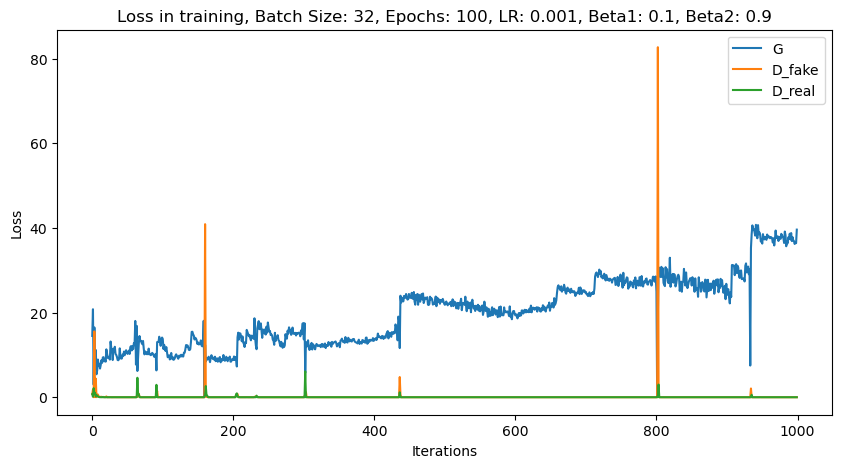

In [9]:
G_4, D_4, epochs_4, dl, Dmizer_4, Gmizer_4, loss, batch_size_4, lr_4, beta1, beta2 = initialize(monet, 32, 0.001, 0.1, 0.9, 100)

train_and_graph(G_4, D_4, dl, epochs_4, Dmizer_4, Gmizer_4, loss, batch_size_4, lr_4, beta1, beta2)

### Batch Size: 64, Epochs: 300, LR: 0.001, Beta1: 0.1, Beta2: 0.9

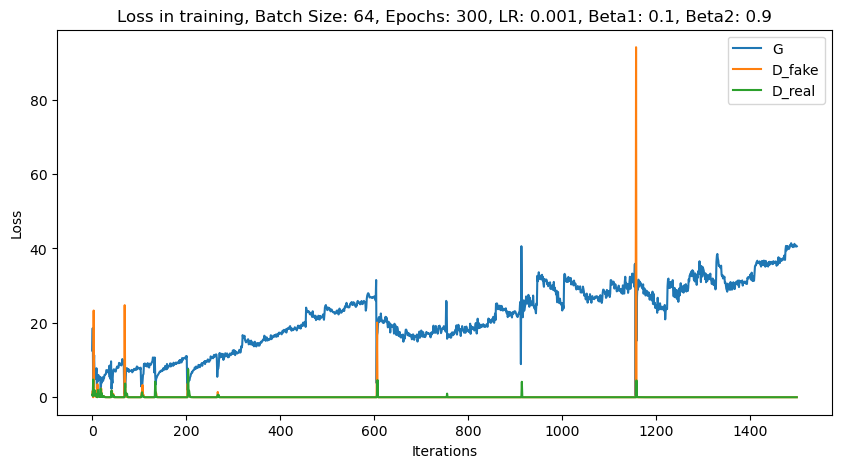

In [10]:
G_5, D_5, epochs_5, dl, Dmizer_5, Gmizer_5, loss, batch_size_5, lr_5, beta1, beta2 = initialize(monet, 64, 0.001, 0.1, 0.9, 300)

train_and_graph(G_5, D_5, dl, epochs_5, Dmizer_5, Gmizer_5, loss, batch_size_5, lr_5, beta1, beta2)


### Batch Size: 64, Epochs: 100, LR: 0.001, Beta1: 0.5, Beta2: 0.9

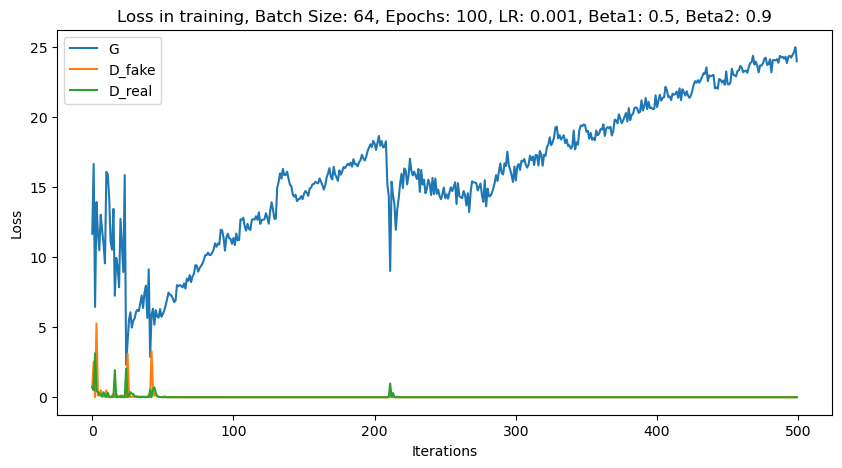

In [11]:
G_6, D_6, epochs_6, dl, Dmizer_6, Gmizer_6, loss, batch_size_6, lr_6, beta1_6, beta2_6 = initialize(monet, 64, 0.001, 0.5, 0.9, 100)

train_and_graph(G_6, D_6, dl, epochs_6, Dmizer_6, Gmizer_6, loss, batch_size_6, lr_6, beta1_6, beta2_6)

From these six models we see the following:
* Decreasing the learning rate by a factor of 10 may lead to a slight decrease in the loss of the Discriminator but it comes with a cost of a large increase in loss for the Generator.
* Increasing the learning rate significantly leads to a large decrease in loss for the Generator but it also removes the Discriminators ability to evaluate fake images effectively. 
* Decreasing the batch size functions similarly to decreasing the learning rate however it leads to larger increases in Generator loss over the iterations.
* Increasing the number of epochs just increases the amount the Generator loss drifts over iterations
* Increasing beta1 increases the speed at which the Generator reaches its lowest loss point but functions similarly to increasing the number of Epochs


Based on the ideas presented here: https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/ we will be choosing our model to submit based on which models' losses appear to be from the most stable model. As such we will choose the base model with Batch size 64, epochs 100, lr 0.001, beta1 0.1, and beta2 0.9.



### Generate Data to submit

In [12]:
photo = getDataset('../input/gan-getting-started/photo_jpg')
best_G = G
if not os.path.exists('../PAINTER_images'):
    os.makedirs('../PAINTER_images')
    
for i in range(len(photo)):
    image_to_save = (best_G(photo).detach().squeeze(0).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    image_to_save = Image.fromarray(image_to_save)
    image_to_save.save(f'../PAINTER_images/{i}.jpg')
    
shutil.make_archive('images', 'zip', '../PAINTER_images')

'/kaggle/working/images.zip'

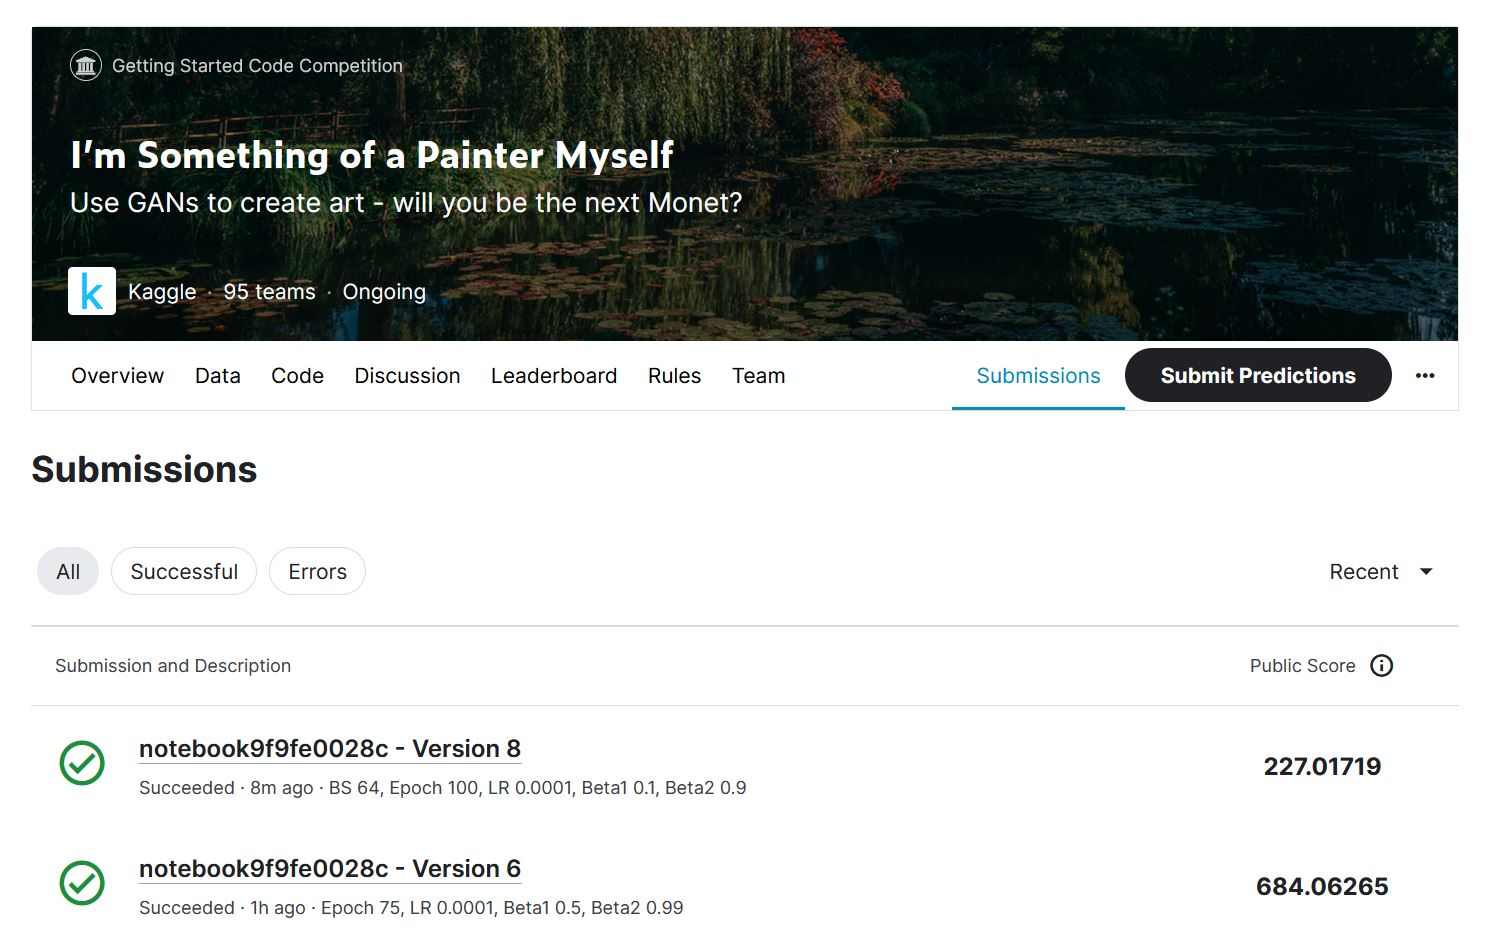

## Conclusion

Overall, our best model was a basic DCGAN using batch size 64, 100 epochs, lr of 0.001, beta1 of 0.1, and beta2 of 0.9. One of the main takeaways from this project was how difficult it is to evaluation GANs directly. It's possible to evaluate them by looking at the images themselves but that is not an algorithmic approach and thus is hard to apply to large sets of outputs such as large batches of images. As a result we had to do a fair bit of extra research into how to evaluate which model was the best. 

There are definitely a few ways to improve this model. First, we could implement a different optimizer than ADAM and see if that yields better results. Secondly, we could use something like FID to score the models' outputs which would give us an algorithmic way to choose models. Thirdly, after implementing FID scoring we could also have manually checks on the image outputs since FID largely scores on image quality and the GAN may be creating quality images but not correct ones.